## 9. UNET++

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 9.1 Loading Data

In [4]:
path = '/content/drive/MyDrive/cs2/'

In [5]:
full_data = pd.read_csv(path+'data/full_data.csv').fillna('')
full_data.head()

,ImageId,rle_1,rle_2,rle_3,rle_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [6]:
#loading train and validation data
train_data = pd.read_csv(path + "data/train_data.csv").fillna('')
validtn_data = pd.read_csv(path + "data/validtn_data.csv").fillna('')

### 9.2 Data Generator Implementation

In [7]:
# Implementing custom data generator
#https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=16, num_classes=None, shuffle=True, preprocess=None):
        self.batch_size = batch_size
        self.df = dataframe
        self.indices = self.df.index.tolist()
        self.preprocess = preprocess
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // (self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True,
                 'width_shift_range':0.1, 'height_shift_range':0.1,}
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32) # image place-holders
        Y = np.empty((self.batch_size,256,1600,4),dtype=np.float32)# 4 masks place-holders
              
        for i, id in enumerate(batch):
          img = Image.open(path+'data/train_images/' + str(self.df['ImageId'].loc[id]))
          X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)#input image
          for j in range(4): #looping for each class
                mask = rle2mask(self.df['rle_'+str(j+1)].loc[id])
                Y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)#mask for each class
                
        # preprocess input
        if self.preprocess!=None: X = self.preprocess(X)

        return X, Y

### 9.3 Utility Functions

In [8]:
#https://www.kaggle.com/titericz/building-and-visualizing-masks
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

#defining function for converting EncodedPixels(rle: run length encoding) to mask
def rle2mask(rle_string, img_shape=(256,1600)):
    '''
    input: EncodedPixels (run-length-encoded) string & image shape:-(width,height)
    output: mask in numpy.ndarray format with shape (256,1600)
    '''
    rle_array = np.array([int(s)for s in rle_string.split()])
    starts_array = rle_array[::2]-1
    lengths_array = rle_array[1::2]
    mask_array = np.zeros(img_shape[0]*img_shape[1],dtype=np.uint8)
    #print(starts_array,lengths_array)
    for i in range(len(starts_array)):
        mask_array[starts_array[i]:starts_array[i]+lengths_array[i]] = 1
    #order='F' because encoded pixels are numbered from top to bottom, then left to right
    return mask_array.reshape(img_shape, order = 'F')

#defining function for converting given mask to EncodedPixels(rle: run length encoding)
def mask2rle(mask_array):
    '''
    input: mask in numpy.ndarray format
    output: EncodedPixels (run-length-encoded) string
    '''
    mask_array = mask_array.T.flatten()
    mask_array = np.concatenate([[0], mask_array, [0]])
    rle_array = np.where(mask_array[1:]!=mask_array[:-1])[0]+1
    rle_array[1::2] -= rle_array[::2]
    rle_string = ' '.join(map(str,rle_array))
    return rle_string

#defining function for calculation of metric dice coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    smoothing_const = 1e-9
    return (2. * intersection + smoothing_const) / (tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smoothing_const)

#defining function for calculation of dice coefficient
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return (1-dice_coefficient(y_true, y_pred))

#defining function for calculation of loss function: binary cross entropy + dice loss
def bce_dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    return binary_crossentropy(y_true, y_pred) + (1-dice_coefficient(y_true, y_pred))

### 9.4 Defining Unet++ Architecture

In [9]:
# defining Unet++ architecture
# https://arxiv.org/abs/1807.10165
# https://towardsdatascience.com/biomedical-image-segmentation-unet-991d075a3a4b
# https://gist.github.com/jinglescode/9d9ed6027e62e389e3165b59209e838e#file-unet-architecture-py

def conv2D_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True ):
    """function to pass Input_tensor through 2- Conv2D layers configured as per the input parameters"""
    # first Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # second Conv2D layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x


def UnetPP_Model(input_image, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Encoder (Contraction Path)
    E1 = conv2D_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(E1)
    p1 = Dropout(dropout)(p1)

    E2 = conv2D_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(E2)
    p2 = Dropout(dropout)(p2)

    E3 = conv2D_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(E3)
    p3 = Dropout(dropout)(p3)

    E4 = conv2D_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(E4)
    p4 = Dropout(dropout)(p4)

    E5 = conv2D_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    #Di1
    D_1_1 = Conv2DTranspose(n_filters * 1, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(E2)
    D_1_1 = Concatenate()([D_1_1, E1])
    D_1_1 = Dropout(dropout)(D_1_1)
    D_1_1 = conv2D_block(D_1_1, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    D_2_1 = Conv2DTranspose(n_filters * 2, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(E3)
    D_2_1 = Concatenate()([D_2_1, E2])
    D_2_1 = Dropout(dropout)(D_2_1)
    D_2_1 = conv2D_block(D_2_1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    D_3_1 = Conv2DTranspose(n_filters * 4, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(E4)
    D_3_1 = Concatenate()([D_3_1, E3])
    D_3_1 = Dropout(dropout)(D_3_1)
    D_3_1 = conv2D_block(D_3_1, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    D_4_1 = Conv2DTranspose(n_filters * 8, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(E5)
    D_4_1 = Concatenate()([D_4_1, E4])
    D_4_1 = Dropout(dropout)(D_4_1)
    D_4_1 = conv2D_block(D_4_1, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    #Di2
    D_1_2 = Conv2DTranspose(n_filters * 1, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(D_2_1)
    D_1_2 = Concatenate()([D_1_2, D_1_1, E1])
    D_1_2 = Dropout(dropout)(D_1_2)
    D_1_2 = conv2D_block(D_1_2, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    D_2_2 = Conv2DTranspose(n_filters * 2, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(D_3_1)
    D_2_2 = Concatenate()([D_2_2, D_2_1, E2])
    D_2_2 = Dropout(dropout)(D_2_2)
    D_2_2 = conv2D_block(D_2_2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    D_3_2 = Conv2DTranspose(n_filters * 4, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(D_4_1)
    D_3_2 = Concatenate()([D_3_2, D_3_1, E3])
    D_3_2 = Dropout(dropout)(D_3_2)
    D_3_2 = conv2D_block(D_3_2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    #Di3
    D_1_3 = Conv2DTranspose(n_filters * 1, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(D_2_2)
    D_1_3 = Concatenate()([D_1_3, D_1_2, D_1_1, E1])
    D_1_3 = Dropout(dropout)(D_1_3)
    D_1_3 = conv2D_block(D_1_3, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    D_2_3 = Conv2DTranspose(n_filters * 2, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(D_3_2)
    D_2_3 = Concatenate()([D_2_3, D_2_2, D_2_1, E2])
    D_2_3 = Dropout(dropout)(D_2_3)
    D_2_3 = conv2D_block(D_2_3, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    #Di4
    D_1_4 = Conv2DTranspose(n_filters * 1, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(D_2_3)
    D_1_4 = Concatenate()([D_1_4, D_1_3, D_1_2, D_1_1, E1])
    D_1_4 = Dropout(dropout)(D_1_4)
    D_1_4 = conv2D_block(D_1_4, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid')(D_1_4)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
#configuring input tensor
input_img = Input((256, 1600, 3), name='img')

model = UnetPP_Model(input_img, n_filters=4, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[dice_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 1600, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 4) 112         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 1600, 4) 16          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 1600, 4) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
#loading train & validation data using DataGenerator class defined
train_batches = DataGenerator(train_data,shuffle=True)
validtn_batches = DataGenerator(validtn_data,shuffle=False)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime, os

# #tensorboard for visualizing loss & metric summary 
# logdir = path+"logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(logdir)

#defining ModelCheckpoint to make a checkpoint when validation dice coefficient improves
checkpoints = ModelCheckpoint(path+'unet++.h5', \
                              monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

#adding ModelCheckpoint & TensorBoard to callback functions list
callbacks_list = [checkpoints]

### 9.5 Traing Model

In [ ]:
# fit model
history = model.fit(train_batches,validation_data=validtn_batches, epochs = 30, callbacks=callbacks_list)

Epoch 1/30
667/667 [==============================] - 3285s 5s/step - loss: 1.4661 - dice_coefficient: 0.0185 - val_loss: 1.0317 - val_dice_coefficient: 0.0578

Epoch 00001: val_dice_coefficient improved from -inf to 0.05776, saving model to /content/drive/MyDrive/cs2/unet++.h5
Epoch 2/30
667/667 [==============================] - 853s 1s/step - loss: 0.9042 - dice_coefficient: 0.1602 - val_loss: 1.0049 - val_dice_coefficient: 0.1859

Epoch 00002: val_dice_coefficient improved from 0.05776 to 0.18591, saving model to /content/drive/MyDrive/cs2/unet++.h5
Epoch 3/30
667/667 [==============================] - 853s 1s/step - loss: 0.6025 - dice_coefficient: 0.4390 - val_loss: 0.5573 - val_dice_coefficient: 0.4859

Epoch 00003: val_dice_coefficient improved from 0.18591 to 0.48587, saving model to /content/drive/MyDrive/cs2/unet++.h5
Epoch 4/30
667/667 [==============================] - 852s 1s/step - loss: 0.5625 - dice_coefficient: 0.4790 - val_loss: 0.5401 - val_dice_coefficient: 0.5062


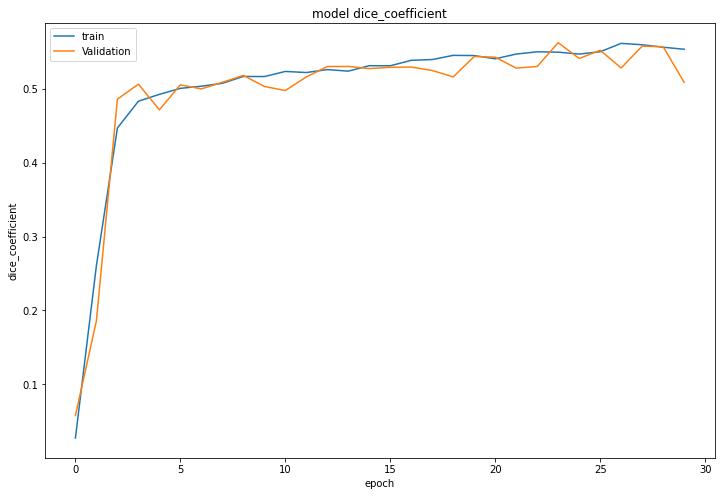

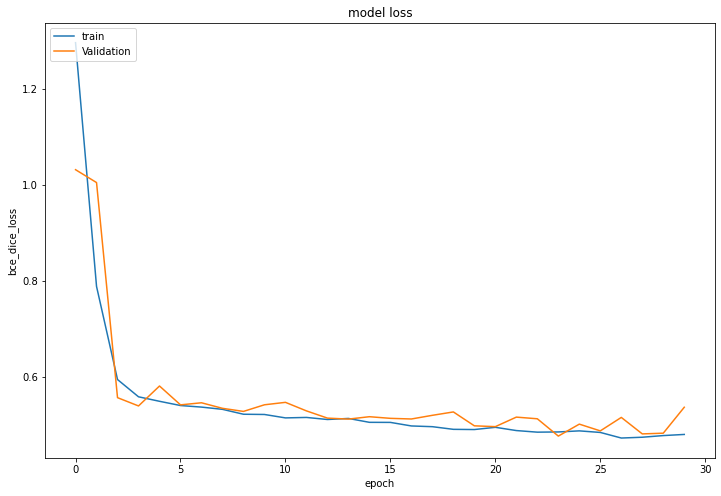

In [ ]:
# Visualizing history for dice_coefficient
plt.figure(figsize=(12, 8))
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('model dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# Visualizing history for loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('bce_dice_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# saving history data for first 30 epochs in csv file
history1 = pd.DataFrame(history.history)
history1.to_csv(path + "data/history1-unet++.csv", index=True)
# saving model(weights upto 30 epochs)
model.save(path+'unet++-30epochs.h5')

### 9.6 Traing Model (31-60 epochs)

In [13]:
#loading saved weights of model trained upto 30 epochs
model.load_weights(path + 'unet++-30epochs.h5')
# fit model
history = model.fit(train_batches,validation_data=validtn_batches, epochs = 30, callbacks=callbacks_list)

Epoch 1/30
667/667 [==============================] - 3265s 5s/step - loss: 0.4774 - dice_coefficient: 0.5565 - val_loss: 0.4867 - val_dice_coefficient: 0.5532

Epoch 00001: val_dice_coefficient improved from -inf to 0.55318, saving model to /content/drive/MyDrive/cs2/unet++.h5
Epoch 2/30
667/667 [==============================] - 856s 1s/step - loss: 0.4692 - dice_coefficient: 0.5642 - val_loss: 0.4771 - val_dice_coefficient: 0.5623

Epoch 00002: val_dice_coefficient improved from 0.55318 to 0.56232, saving model to /content/drive/MyDrive/cs2/unet++.h5
Epoch 3/30
667/667 [==============================] - 856s 1s/step - loss: 0.4623 - dice_coefficient: 0.5711 - val_loss: 0.4787 - val_dice_coefficient: 0.5616

Epoch 00003: val_dice_coefficient did not improve from 0.56232
Epoch 4/30
667/667 [==============================] - 857s 1s/step - loss: 0.4759 - dice_coefficient: 0.5573 - val_loss: 0.4823 - val_dice_coefficient: 0.5572

Epoch 00004: val_dice_coefficient did not improve from 0.

In [14]:
# saving history data for 31-60 epochs in csv file
history2 = pd.DataFrame(history.history)
history2.to_csv(path + "data/history2-unet++.csv", index=True)
# saving model(weights upto 60 epochs)
model.save(path+'unet++-31-60epochs.h5')

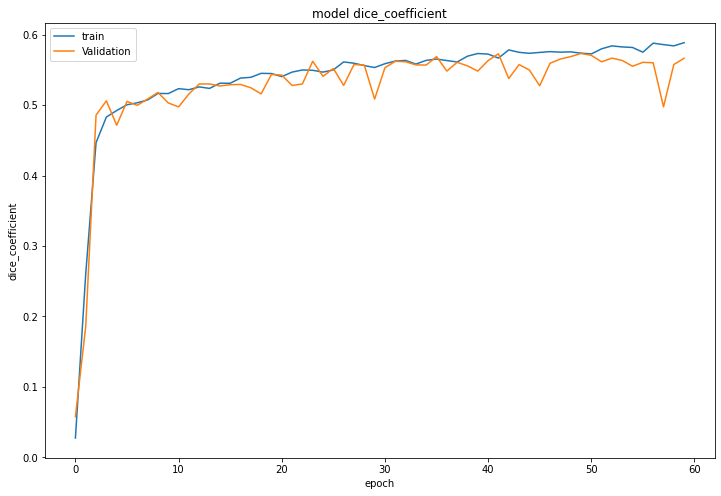

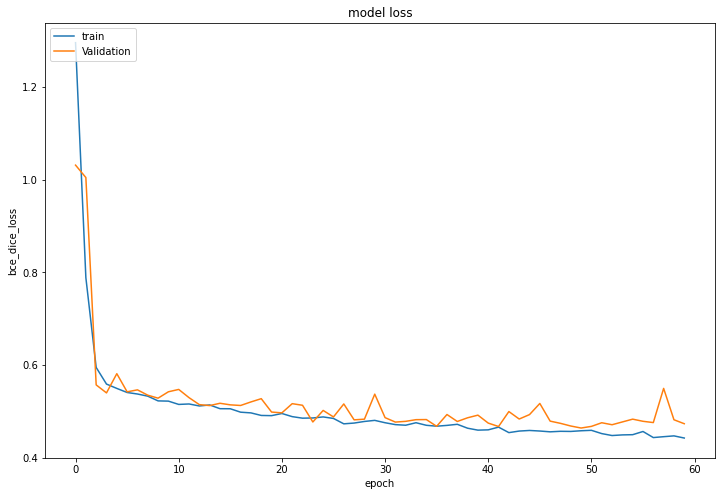

In [15]:
#loading saved history of 1-30 epochs
history1 = pd.read_csv(path + "data/history1-unet++.csv")
#loading saved history of 30-60 epochs
history2 = pd.read_csv(path + "data/history2-unet++.csv")

# Visualizing history(1-60 epochs) for dice_coefficient
plt.figure(figsize=(12, 8))
plt.plot(history1['dice_coefficient'].tolist() + history2['dice_coefficient'].tolist())
plt.plot(history1['val_dice_coefficient'].tolist() + history2['val_dice_coefficient'].tolist())
plt.title('model dice_coefficient')
plt.ylabel('dice_coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# Visualizing history(1-60 epochs) for loss
plt.figure(figsize=(12, 8))
plt.plot(history1['loss'].tolist() + history2['loss'].tolist())
plt.plot(history1['val_loss'].tolist() + history2['val_loss'].tolist())
plt.title('model loss')
plt.ylabel('bce_dice_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

### 9.7 Visualizing Model Predictions

In [16]:
# evaluating model(best weights) with the validation batch
model.load_weights(path + 'unet++.h5')
loss, dc= model.evaluate(validtn_batches,verbose=1)
print('loss:',loss, 'dice_coefficient:',dc)

117/117 [==============================] - 44s 373ms/step - loss: 0.4642 - dice_coefficient: 0.5734
loss: 0.46424591541290283 dice_coefficient: 0.5734127163887024


In [17]:
#defining function to display GroundTruth & Predicted mask images for a given imageId
def visualize_model_prediction(img_id):
    fig, axs = plt.subplots(4, 3, figsize=(16,8))
    img_obj = cv2.imread(path+'data/train_images/'+ img_id)
    masks_actual = full_data[full_data['ImageId'] == img_id]
    x = np.empty((1,256,1600,3),dtype=np.float32) # image place-holders
    x[0,] = Image.open(path+'data/train_images/' + img_id)
    masks_predicted = model.predict(x)
    for i in range(4):
        axs[i,0].imshow(img_obj)
        axs[i,0].set_title(img_id)
        axs[i,1].imshow(rle2mask(masks_actual['rle_'+str(i+1)].iloc[0]))
        axs[i,1].set_title("Actual mask for Class '{}'".format(i+1) )
        axs[i,2].imshow(masks_predicted[0,:,:,i])
        axs[i,2].set_title("Predicted mask for Class '{}'".format(i+1))
    plt.show()

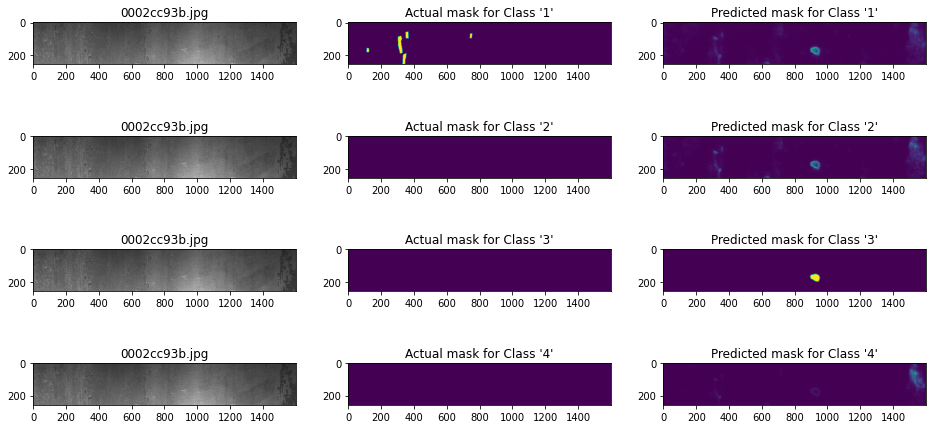

In [18]:
visualize_model_prediction('0002cc93b.jpg')

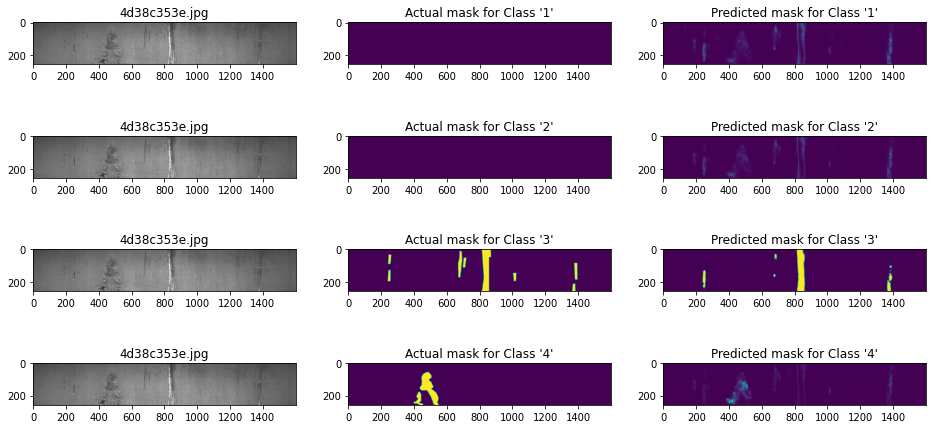

In [19]:
visualize_model_prediction('4d38c353e.jpg')

### 9.8 Preparing Data for submission

In [20]:
class PredictDataGenerator(tf.keras.utils.Sequence):
    def __init__(self,dataframe, list_idcs, batch_size=32, ):
        self.batch_size = batch_size
        self.df = dataframe
        self.list_idcs = list_idcs
        self.indices = self.df.index.tolist()
        self.rem = len(self.list_idcs) % (self.batch_size)
        self.on_epoch_end()

    def __len__(self):
         return len(self.list_idcs) // (self.batch_size)
#         if (self.rem) == 0:
#             return len(self.list_idcs) // (self.batch_size)
#         else:
#             return (len(self.list_idcs) // (self.batch_size) )+1

    def __getitem__(self, index):
        index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
#         if ((index + 1) * self.batch_size) < len(self.list_idcs):
#             index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
#         else:
#             index = self.indices[index * self.batch_size: (index * self.batch_size)+ self.rem]
        batch = [self.list_idcs[k] for k in index]
        
        X = self.__get_data(batch)
         
        return X
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))

    def __get_data(self, batch):
        X = np.empty((self.batch_size,256,1600,3),dtype=np.float32) # image place-holders
              
        for i, id in enumerate(batch):
            img = Image.open(path + 'data/test_images/' + str(self.df['ImageId'].loc[id]))
            X[i,] = img#input image

        return X

In [21]:
test_img_IDs = list(os.listdir(path + 'data/test_images/'))
test_imgsIds_df = pd.DataFrame({'ImageId': test_img_IDs})
print(len(test_imgsIds_df))
test_imgsIds_df.head()

5506


,ImageId
0,d3dcedbd7.jpg
1,db7cff638.jpg
2,d3764cee5.jpg
3,d387d301f.jpg
4,d221d2a3f.jpg


In [22]:
SubmissionDf = pd.DataFrame(columns = ['ImageId','EncodedPixels','ClassId'])

In [23]:
for i in range(0,len(test_imgsIds_df),320):
    batch_idcs =  list(range(i, min(test_imgsIds_df.shape[0], i + 320)))#.iloc[batch_idcs]
    if len(batch_idcs)== 320:        
        test_subbatch = PredictDataGenerator(dataframe = test_imgsIds_df,
                                             list_idcs = batch_idcs)
    else:
        test_subbatch = PredictDataGenerator(dataframe = test_imgsIds_df,
                                             list_idcs = batch_idcs,
                                             batch_size= len(batch_idcs))
    #print(len(test_subbatch))
    subbatch_pred_masks = model.predict(test_subbatch)
    #print(len(subbatch_pred_masks))
    #break
    for j, idx in tqdm(enumerate(batch_idcs)):
        filename = test_imgsIds_df['ImageId'].iloc[idx]
        rle1 = mask2rle(subbatch_pred_masks[j,:,:,0].round().astype(int))
        rle2 = mask2rle(subbatch_pred_masks[j,:,:,1].round().astype(int))
        rle3 = mask2rle(subbatch_pred_masks[j,:,:,2].round().astype(int))
        rle4 = mask2rle(subbatch_pred_masks[j,:,:,3].round().astype(int))
        df = pd.DataFrame({'ImageId':[filename]*4,
                      'EncodedPixels': [rle1,rle2,rle3,rle4],
                      'ClassId':['1', '2', '3', '4']})
        SubmissionDf = SubmissionDf.append(df,ignore_index=True)

320it [00:03, 85.75it/s]
320it [00:03, 85.44it/s]
320it [00:03, 83.15it/s]
320it [00:03, 83.40it/s]
320it [00:03, 83.65it/s]
320it [00:03, 82.02it/s]
320it [00:03, 82.41it/s]
320it [00:04, 78.65it/s]
320it [00:04, 78.02it/s]
320it [00:03, 82.68it/s]
320it [00:03, 81.32it/s]
320it [00:04, 79.56it/s]
320it [00:03, 80.27it/s]
320it [00:03, 81.17it/s]
320it [00:04, 79.31it/s]
320it [00:03, 80.40it/s]
320it [00:03, 81.45it/s]
66it [00:00, 81.35it/s]


In [24]:
SubmissionDf.sort_values(by=['ImageId', 'ClassId'], inplace=True)
SubmissionDf['ImageId_ClassId'] = SubmissionDf['ImageId'] + '_' + SubmissionDf['ClassId']
print(SubmissionDf.shape)
SubmissionDf.head(10)

(22024, 4)


,ImageId,EncodedPixels,ClassId,ImageId_ClassId
20016,0000f269f.jpg,,1,0000f269f.jpg_1
20017,0000f269f.jpg,,2,0000f269f.jpg_2
20018,0000f269f.jpg,145303 13 145545 47 145798 60 145870 4 145875 ...,3,0000f269f.jpg_3
20019,0000f269f.jpg,,4,0000f269f.jpg_4
20004,000ccc2ac.jpg,,1,000ccc2ac.jpg_1
20005,000ccc2ac.jpg,,2,000ccc2ac.jpg_2
20006,000ccc2ac.jpg,,3,000ccc2ac.jpg_3
20007,000ccc2ac.jpg,,4,000ccc2ac.jpg_4
20012,002451917.jpg,,1,002451917.jpg_1
20013,002451917.jpg,,2,002451917.jpg_2


In [25]:
SubmissionDf.to_csv(path+'submission-unet++.csv', index=False)

### 9.9 Kaggle Submission Score

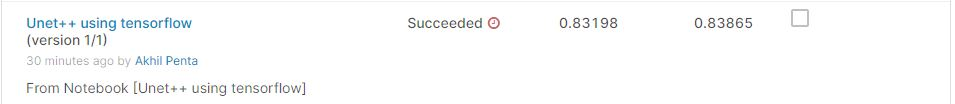

In [1]:
#Kaggle Score
from IPython.display import Image
Image(filename='unet++.JPG') 